In [1]:
%pwd
import sys
print(sys.executable)
%pip install seaborn
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install einops
%pip install torchsummary





/share/hackathon-env/bin/python3.10
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: /share/hackathon-env/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: /share/hackathon-env/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: /share/hackathon-env/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to use

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib
from plot import create_plots
%pwd

'/home/trainee27'

In [3]:
df = pd.read_csv('smart_meters_london_2013.csv',parse_dates=['timestamp'])


In [4]:
df.set_index('timestamp', inplace=True)

In [5]:
df.head()

0      1      2      3    4      5      6      7  \
timestamp                                                                   
2013-01-01 00:00:00  0.460  3.888  0.000  0.207  0.0  0.451  0.962  0.579   
2013-01-01 01:00:00  0.426  2.603  0.158  0.106  0.0  0.375  1.121  1.340   
2013-01-01 02:00:00  0.411  2.159  0.000  0.069  0.0  0.312  0.373  1.431   
2013-01-01 03:00:00  0.395  2.040  0.170  0.065  0.0  0.199  0.421  0.413   
2013-01-01 04:00:00  0.221  1.495  0.000  0.058  0.0  0.096  0.303  0.230   

                         8      9  ...   4115   4116   4117   4118   4119  \
timestamp                          ...                                      
2013-01-01 00:00:00  0.016  0.660  ...  0.585  0.256  3.311  0.190  0.263   
2013-01-01 01:00:00  0.107  0.420  ...  0.493  0.192  1.695  0.222  0.231   
2013-01-01 02:00:00  0.024  0.242  ...  0.423  0.200  1.038  0.268  0.236   
2013-01-01 03:00:00  0.010  0.149  ...  0.182  0.262  0.586  0.119  0.188   
2013-01-01 04:00:00  0.107  0.280  ...  0.262  0.205  0.555  0.149  0.165   

                      4120   4121   4122   4123   4124  
timestamp                                               
2013-01-01 00:00:00  0.246  0.141  0.547  0.215  0.119  
2013-01-01 01:00:00  0.221  0.131  0.474  0.227  0.103  
2013-01-01 02:00:00  0.207  0.131  0.252  0.220  0.285  
2013-01-01 03:00:00  0.220  0.104  0.091  0.202  0.097  
2013-01-01 04:00:00  0.238  0.119  0.086  0.208  0.103  

[5 rows x 4125 columns]

In [6]:
time_data = df["0"]


In [7]:
!nvidia-smi


Sun Feb 23 08:18:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:81:00.0 Off |                    0 |
| N/A   29C    P0             63W /  500W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
# Add the tts-gan repository folder to the Python path
import sys
sys.path.append('/home/trainee27/tts-gan')



import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

from GANModels import Generator, Discriminator, Encoder
from torch.utils.data import Dataset, DataLoader

In [8]:
# df -> dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, df):
        # The DataFrame "df" has the timestamps as index and each column as one sample.
        # Convert the DataFrame values and then transpose so that each row is one sample.
        self.data = df.values.T  # Shape becomes: (num_samples, sequence_length)
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        # Reshape the sample to (channels, height, width)
        sample = sample.reshape(1, 1, -1)
        return torch.tensor(sample, dtype=torch.float32)

In [9]:
# restrucure DF 

df_downsampled = df.iloc[::4, :]
data_tensor = TimeSeriesDataset(df_downsampled)

# We'll use only the first 100 samples for this test run 
#subset_dataset = Subset(data_tensor, indices=range(100))

loader = DataLoader(data_tensor, batch_size=32, shuffle=True)



In [11]:
# 3. Instantiate your GAN components
gen = Generator(seq_len=2190, channels=1, latent_dim=1000, patch_size=2)
# Create a discriminator that processes the time series
disc = Discriminator(in_channels=1, patch_size=2, emb_size=50, seq_length=2190, depth=3, n_classes=1)

# Optionally move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen.to(device)
disc.to(device)

# -------------------------------------------------------------------
# 4. Define optimizers and loss
optimizer_G = optim.Adam(gen.parameters(), lr=0.00022)
optimizer_D = optim.Adam(disc.parameters(), lr=0.0002)
criterion = nn.MSELoss()  # Using MSELoss for LSGAN loss

In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
from GANModels import Generator, Discriminator, Encoder  # Make sure these classes have the new arguments

# Create models with new parameters
gen = Generator(seq_len=2190, 
                channels=1, 
                latent_dim=1000, 
                cond_dim=1000,    # The condition dimension (should match encoder output)
                patch_size=2,
                embed_dim=10,     # or any desired value
                depth=3,
                num_heads=5,
                forward_drop_rate=0.5,
                attn_drop_rate=0.5,
                multi_scale=True,
                scale_small_factor=4,
                scale_med_factor=2, 
                res_weight_small=0.1,
                res_weight_med=0.2)

disc = Discriminator(in_channels=1, 
                     patch_size=2, 
                     emb_size=50, 
                     seq_length=2190, 
                     depth=3, 
                     n_classes=1,
                     multi_scale=True,
                     gp_weight=10.0)

enc = Encoder(in_channels=1, 
              patch_size=2, 
              emb_size=64, 
              seq_length=2190,
              depth=8, 
              num_heads=4, 
              latent_dim=1000, 
              drop_p=0.1, 
              forward_drop_p=0.1)

# Optionally move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen.to(device)
disc.to(device)
enc.to(device)

# ------------------------------------------------------
# 2. Define optimizers and loss function
# ------------------------------------------------------
optimizer_G = optim.Adam(gen.parameters(), lr=0.00022)
optimizer_D = optim.Adam(disc.parameters(), lr=0.0002)
optimizer_E = optim.Adam(enc.parameters(), lr=0.0002)
criterion = nn.MSELoss()  # Using MSELoss for LSGAN loss

In [ ]:
for epoch in range(num_epochs):
    print("Epoch", epoch+1)
    for real_data in loader:
        real_data = real_data.to(device)
        batch_size = real_data.size(0)

        # Create labels for LSGAN (valid = 1, fake = 0)
        valid = torch.ones(batch_size, 1, device=device)
        fake  = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        #  Compute Conditioning using Encoder on Real Data
        # ---------------------
        # Use the encoder on real data to get the condition vector.
        # If your Encoder returns multiple outputs (latent, mu, logvar), use only the latent.
        latent_cond, _, _ = enc(real_data)
        # Detach the condition so that it doesn't propagate gradients twice.
        latent_cond_target = latent_cond.detach()

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()
        # Sample random noise as generator input
        z = torch.randn(batch_size, 1000, device=device)
        # Generate fake data using the noise and the condition from real data
        generated_data = gen(z, latent_cond)
        # The generator is encouraged to fool the discriminator:
        g_loss = criterion(disc(generated_data), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = criterion(disc(real_data), valid)
        fake_loss = criterion(disc(generated_data.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Encoder
        # ---------------------
        # Encourage the encoder (when processing generated data) to recover the condition
        optimizer_E.zero_grad()
        latent_recon, _, _ = enc(generated_data.detach())
        # Use the detached condition vector as the target to avoid backward through the same graph twice
        enc_loss = criterion(latent_recon, latent_cond_target)
        enc_loss.backward()
        optimizer_E.step()

    print(f"Epoch {epoch+1}/{num_epochs} -- d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, enc_loss: {enc_loss.item():.4f}")

    # ---------------------
    #  Save Models Every 15 Epochs
    # ---------------------
    if (epoch + 1) % 15 == 0:
        torch.save(gen.state_dict(), f"generator_epoch_{epoch+1}_dL_{d_loss.item():.4f}_gL_{g_loss.item():.4f}.pth")
        torch.save(disc.state_dict(), f"discriminator_epoch_{epoch+1}_dL_{d_loss.item():.4f}_gL_{g_loss.item():.4f}.pth")
        torch.save(enc.state_dict(), f"encoder_epoch_{epoch+1}_encL_{enc_loss.item():.4f}.pth")
        print(f"Models saved at epoch {epoch+1}")

Epoch 1
Epoch 1/100 -- d_loss: 0.3452, g_loss: 0.2210, enc_loss: 0.0213
Epoch 2
Epoch 2/100 -- d_loss: 0.2311, g_loss: 0.2751, enc_loss: 0.1575
Epoch 3


In [29]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [15]:
torch.cuda.empty_cache()
samples = []  # List to store each generated column

with torch.no_grad():
    for i in range(500):
        print(i)
        z = torch.randn(batch_size, 1000, device=device)
        generated_data = gen(z)  # generated_data.shape: (batch_size, 1, 1, 2190)
        
        # Extract and move the sample to CPU immediately
        sample = generated_data[0, 0, 0, :].cpu().numpy()
        samples.append(sample)
        
        # Delete the tensor and clear cache to free GPU memory
        del generated_data, z
        torch.cuda.empty_cache()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
# Convert list to numpy array and transpose so that shape becomes (2190, 500)
generated_array = np.array(samples).T  # Now shape is (2190, 500)

# Create DataFrame with the same index as df_downsampled and column names "0", "1", ..., "499"
df_generated = pd.DataFrame(generated_array,
                            index=df_downsampled.index,
                            columns=[str(i) for i in range(500)])

# Now, df_generated has shape (2190, 500)
print(df_generated.shape)

(2190, 500)


In [18]:
def repeat_rows(df, factor=4):
    # Repeat the index values and use .loc to get the repeated rows.
    repeated_df = df.loc[df.index.repeat(factor)].copy()
    repeated_df
    
    return repeated_df

In [19]:
# CHECK IF WE CAN USE FULL SAMPLE IN create_plots

#df_first500 = df_downsampled.iloc[:, :500]

In [20]:
# Restore the row structure by repeating each row 4 times
df_generated_restored = repeat_rows(df_generated, factor=4)
df_first500_restored = repeat_rows(df_downsampled, factor=4)

# Now replace the index with the original timestamp index
df_generated_restored.index = df.index
df_first500_restored.index = df.index

In [21]:
fig_dict, rmse_dict = create_plots(df_generated_restored, df_first500_restored)

In [22]:
score = 0
for item in rmse_dict.values():
    score += item.loc[item['statistic'] != 'median', 'value'].sum()

print(score)

270364.25457269


In [23]:
import matplotlib.pyplot as plt

def plot_time_series(df, columns):

  plt.figure(figsize=(200, 6))
  for col in columns:
    if col in df.columns:
        plt.plot(df.index, df[col], label=col)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")
  plt.xlabel("Time")
  plt.ylabel("Values")
  plt.title("Time Series Plot")
  plt.legend()
  plt.grid(True)
  plt.show()


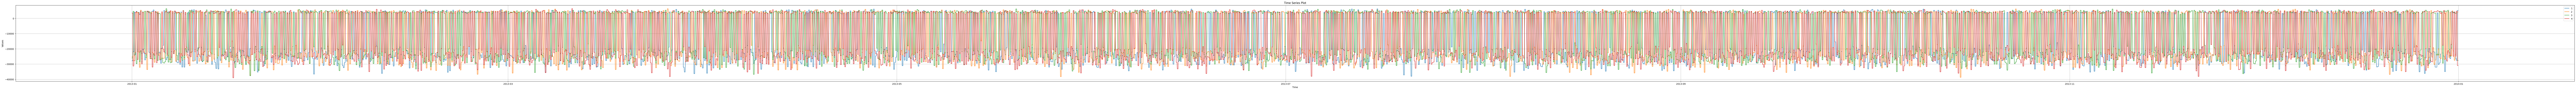

In [24]:
col_names = [str(i) for i in range(1,5)]
plot_time_series(df_generated_restored,col_names)